This notebooks lives at 

## Multi-modal data

Generate synthetic data such that there are regions of the $x$-axis that map to multiple y-values: 

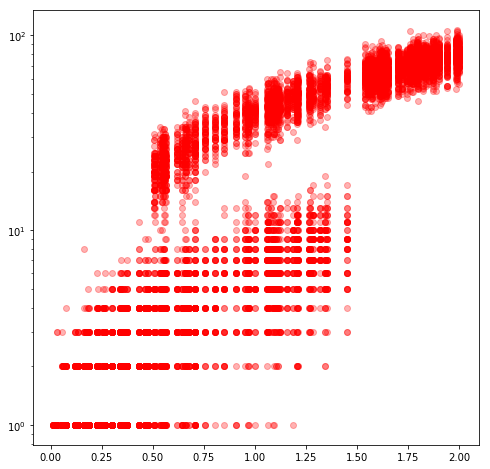

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

def prior_vector(x_): 
    if x_ < 0.5: 
        return np.array([1, 0])
    elif x_ < 1.5: 
        return np.array([0.5, 0.5])
    else: 
        return np.array([0, 1])

def lmbda(component_, x_): 
    return 10**(0.8*(component_+1)) * x_ 
    
def mean_vector(x_): 
    return np.array([lmbda(component_=0, x_=x_), lmbda(component_=1, x_=x_)])
    
def sample_lambdas(x_, number_of_lambdas=100): 
    components = np.random.choice(a=2, size=number_of_lambdas, p=prior_vector(x_))
    return lmbda(components, x_)
        
def sample_from_mixture_distribution(x_):    
    lambdas = sample_lambdas(x_)
    # https://github.com/numpy/numpy/issues/7843 ...
    return np.random.poisson(lam=lambdas[:, np.newaxis], size=(len(lambdas), 1)) 

def generate_data():
    xs = []
    ys = []
    for x_ in np.random.uniform(0, 2, 100): 
        ys_temp = sample_from_mixture_distribution(x_)
        xs.extend(x_*np.ones_like(ys_temp)) 
        ys.extend(ys_temp)
    return np.array(xs), np.array(ys)
          
x, y = generate_data()    

plt.figure(figsize=(8, 8))
plt.plot(x, y, 'ro', alpha=0.3)
plt.yscale('log')

## Mixture-network model
Following [Bishop](http://publications.aston.ac.uk/373/1/NCRG_94_004.pdf), we create a neural network that, when given a single value of $x$, outputs `number_mixture_components` tuples that together parametrize a mixture of elementary distributions: 

In [2]:
import tensorflow as tf
from keras.layers import Input, Dense
from tensorflow.keras import regularizers

x_tensor = Input(shape=(1,))
hidden = Dense(20, activation=tf.nn.tanh, kernel_regularizer=regularizers.l2(0.01))(x_tensor)
number_mixture_components = 10
priors = Dense(number_mixture_components, activation=tf.nn.softmax)(hidden)
means = Dense(number_mixture_components, activation=tf.nn.softplus)(hidden)

import tensorflow_probability as tfp
tfd = tfp.distributions

# https://en.wikipedia.org/wiki/Mixture_distribution
# https://en.wikipedia.org/wiki/Compound_probability_distribution
mixture_distribution = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=priors),
    components_distribution=tfd.Poisson(rate=means))

Using TensorFlow backend.


Use the so-computed probability distribution of $y$ to compute the loss function:

In [3]:
y_tensor = tf.placeholder(tf.float32, shape=[None, 1])
loss = -tf.reduce_sum(mixture_distribution.log_prob(tf.reshape(y_tensor, [-1])))

Notice that we flattened `y_tensor` before passing it off to `mixture_distribution.log_prob()`. Here's why: 

In [12]:
with tf.Session() as debug_session: 
    debug_session.run(tf.global_variables_initializer())
    print('mixture_distribution.log_prob(y_tensor) computes each of the 3 x-dependent likelihood functions on each of the 3 y values:')
    print(debug_session.run(mixture_distribution.log_prob([[1], [2], [3]]), 
                           feed_dict={x_tensor: [[1], [2], [3]]}))
    print('the above leads to inappropriately summing over all elements in a 3x3 matrix in tf.reduce_sum(), which is NOT the log likelihood of the data')
    print('')
    print('mixture_distribution.log_prob(tf.reshape(y_tensor, [-1])) computes each of the 3 likelihood functions on the corresponding 3 y-values:')
    print(debug_session.run(mixture_distribution.log_prob([1, 2, 3]), 
                           feed_dict={x_tensor: [[1], [2], [3]]}))
    print('the above leads to the expected sum of 3 numbers in tf.reduce_sum(), which IS the correct log likelihood of the data')

mixture_distribution.log_prob(y_tensor) computes each of the 3 x-dependent likelihood functions on each of the 3 y values:
[[-1.1112616 -1.1655859 -1.1964211]
 [-2.224642  -2.2371073 -2.194483 ]
 [-3.6964872 -3.6043622 -3.4506855]]
the above leads to inappropriately summing over all elements in a 3x3 matrix in tf.reduce_sum(), which is NOT the log likelihood of the data

mixture_distribution.log_prob(tf.reshape(y_tensor, [-1])) computes each of the 3 likelihood functions on the corresponding 3 y-values:
[-1.1112616 -2.2371073 -3.4506855]
the above leads to the expected sum of 3 numbers in tf.reduce_sum(), which IS the correct log likelihood of the data


For more on this, see: 
* "Broadcasting, aka Why Is This So Confusing?" at: 
https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/TensorFlow_Distributions_Tutorial.ipynb
* the graphical depiction of broadcasting rules at: 
https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html


Complete the specification of the tensorflow graph: 

In [5]:
train_ops = tf.train.AdamOptimizer().minimize(loss)

## Training the mixture-network model

In [6]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for epoch in range(10000):
        _, loss_ = session.run([train_ops, loss], feed_dict={x_tensor: x, y_tensor: y})
        if (epoch + 1) % 1000 == 0:
            print(str(epoch + 1) + " : " + str(loss_))

    x_test = np.linspace(0, 2, 100).reshape((-1, 1))
    y_test_predicted = session.run(mixture_distribution.sample(), feed_dict={x_tensor: x_test})

    priors_predicted, means_predicted = session.run([priors, means], feed_dict={x_tensor: x})    

1000 : 242013.81
2000 : 130268.875
3000 : 83270.53
4000 : 60792.89
5000 : 45989.156
6000 : 37753.273
7000 : 33431.508
8000 : 31500.98
9000 : 30861.914
10000 : 30521.883


## Evaluating the fit

Let's see how samples from the model compare with the original data: 

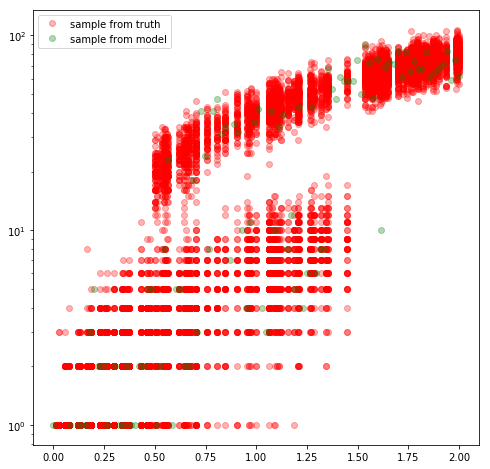

In [7]:
plt.figure(figsize=(8, 8))
plt.plot(x, y, 'ro', alpha=0.3, label='sample from truth')
plt.plot(x_test, y_test_predicted, 'go', alpha=0.3, label='sample from model')
plt.yscale('log')
_ = plt.legend()

Looks pretty good. 

Let's compare the predicted means of each of the mixture components with the true means: 

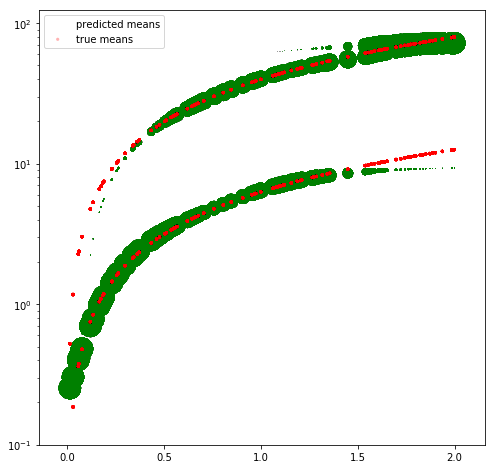

In [8]:
means_true = []
for x_ in x: 
    means_true.append(mean_vector(float(x_))) 
means_true = np.array(means_true)

plt.figure(figsize=(8, 8))
for mixture_component in range(number_mixture_components): 
    plt.scatter(x, means_predicted[:, mixture_component], s=500*priors_predicted[:, mixture_component], facecolors='g', edgecolors='none', alpha=0.3, label=('predicted means' if mixture_component==0 else ''))
for mixture_component in range(2): 
    plt.scatter(x, means_true[:, mixture_component], s=10, facecolors='r', edgecolors='none', alpha=0.3, label=('true means' if mixture_component==0 else ''))
plt.yscale('log')
_ = plt.ylim(ymin=1e-1)
_ = plt.legend()

Here, I've made the marker size of each component proportional to the predicted probability of that component. You can see that that those components with large predicted probabilities have predicted means that coincide with the true means. 